In [1]:
from SymbolicDSGE import ModelConfig, ModelParser, DSGESolver
import sympy as sp
from warnings import catch_warnings, simplefilter
import numpy as np

In [2]:
conf = ModelParser("MODELS/POST82.yaml").get()

In [3]:
with catch_warnings():
    simplefilter(action="ignore")
    mat = sp.Matrix(conf.equations.model)
mat

Matrix([
[                                   Eq(Pi(t), beta*Pi(t + 1) + kappa*x(t) + z(t))],
[                        Eq(x(t), -tau_inv*(-Pi(t + 1) + r(t)) + g(t) + x(t + 1))],
[Eq(r(t + 1), e_R + rho_r*r(t) + (1 - rho_r)*(psi_pi*Pi(t + 1) + psi_x*x(t + 1)))],
[                                                  Eq(g(t + 1), e_g + rho_g*g(t))],
[                                                  Eq(z(t + 1), e_z + rho_z*z(t))]])

In [4]:
sol = DSGESolver(conf)
comp = sol.compile(variable_order=conf.variables, n_state=3, n_exog=2)
conf.variables

[g, z, r, Pi, x]

In [5]:
solved = sol.solve(
    comp,
    steady_state=np.asarray([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float),
    log_linear=False,
)

C:\Users\guney\Documents\GitHub\ThesisDraft\SymbolicDSGE\solver.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  p = np.asarray(mdl.p, dtype=float64)
C:\Users\guney\Documents\GitHub\ThesisDraft\SymbolicDSGE\solver.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  f = np.asarray(mdl.f, dtype=float64)


In [6]:
solved.policy.eig

array([0.27920118+0.j, 0.83000003+0.j, 0.84999992+0.j, 2.56517116+0.j,
       1.18470582+0.j])

In [7]:
params = {
    p.name: float(conf.calibration.parameters[p])
    for p in conf.parameters
    if p in conf.calibration.parameters
}

# state at time t
s = np.array([0.05, 0.077, 0.06])  # or any test state
P = solved.policy.p
F = solved.policy.f

# controls at time t (jump variables)
c = F @ s

cur = np.concatenate([s, c])

# expected next state (NO shock)
s1 = P @ s
c1 = F @ s1
fwd = np.concatenate([s1, c1])

res = solved.compiled.equations(fwd, cur, params)
print(res)

[np.complex128(-1.0494781432779376e-09+0j)
 np.complex128(8.938198320374013e-09+0j) -e_R - 4.89569941617557e-9
 1.52736900210781e-9 - e_g -e_z - 6.02379433833899e-9]


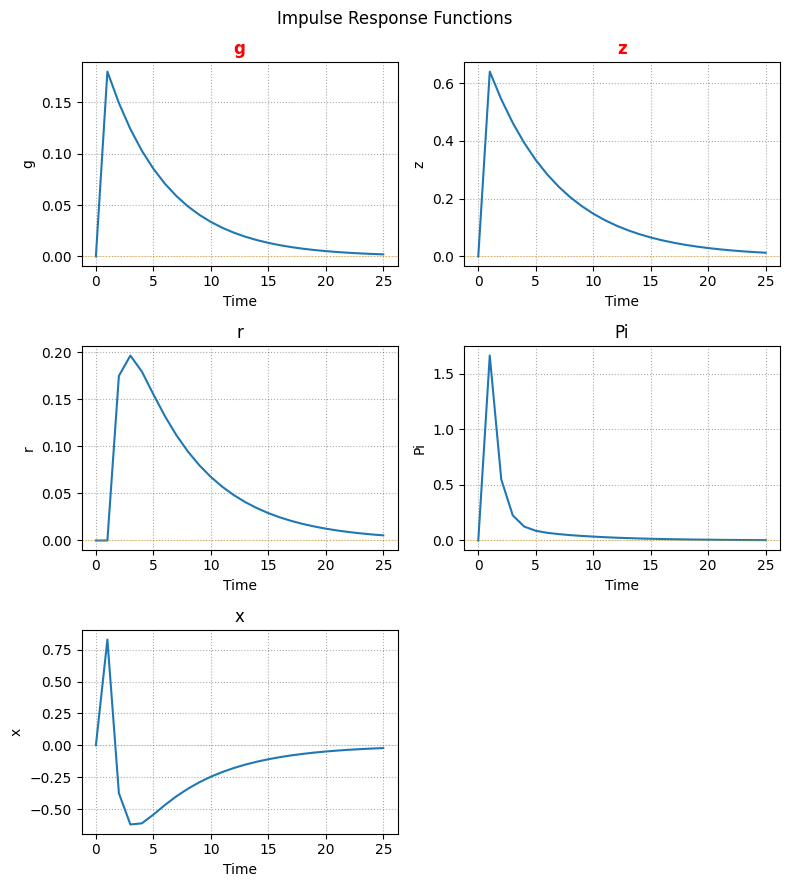

In [8]:
solved.transition_plot(25, ["g", "z"], 1.0)